# Directory

In [21]:
# Set root dir
import os

os.chdir("/")
print("Current Working Directory:", os.getcwd())

# !!CHANGE THIS!!
working_dir="/BigData"

dataset_dir=f"{working_dir}/dataset"

dataset_original_csv = f'{dataset_dir}/creditScores.csv'

dataset_csv_path = f'{dataset_dir}/creditScores_csv'
dataset_json_path = f'{dataset_dir}/creditScores_json'
dataset_parquet_path = f'{dataset_dir}/creditScores_parquet'
dataset_orc_path = f'{dataset_dir}/creditScores_orc'
dataset_avro_path = f'{dataset_dir}/creditScores_avro'

clean_dataset_path = f'{dataset_dir}/clean_creditScores_orc'
final_dataset_path = f'{dataset_dir}/final_creditScores_orc'

outputs = f"{working_dir}/output"
pipeline_model_path = f"{outputs}/pipeline_model"
models_paths = f"{outputs}/models"

os.chdir(working_dir)
print(f"New working directory: {working_dir}")


Current Working Directory: /
New working directory: /BigData


In [22]:
from pyspark import SparkConf
from pyspark.ml.feature import StringIndexer, OneHotEncoder, SQLTransformer
from pyspark.sql import functions as F, SparkSession, DataFrame
from pyspark.sql.functions import *
from pyspark.ml import Transformer, PipelineModel, Pipeline
from pyspark.ml.param.shared import HasInputCol, HasOutputCol, HasInputCols, Param, Params
from pyspark.ml.util import DefaultParamsReadable, DefaultParamsWritable
from pyspark.sql.window import Window
from pyspark.ml.classification import RandomForestClassifier, MultilayerPerceptronClassifier
from pyspark.ml.evaluation import MulticlassClassificationEvaluator
from pyspark.ml.classification import LogisticRegression
from pyspark.ml.feature import PCA
import matplotlib.pyplot as plt
import pandas as pd
import seaborn as sns
from sklearn.metrics import confusion_matrix, roc_curve, auc
import numpy as np

proj_conf = SparkConf()\
        .setAppName("projBigData_modelsPerformance")\
        .set("spark.driver.memory", "16g")\
        .set("spark.jars.packages", "org.apache.spark:spark-avro_2.12:3.5.0")

spark = SparkSession.builder.config(conf=proj_conf).getOrCreate()

In [3]:
# spark.stop()

# Data

## Read dataset

This is the output dataset of the last Script (whiout the pipeline)

In [23]:
df = spark.read.orc(final_dataset_path)
df.show(truncate=False)

+-----------+--------+---+-------------+-------------+---------------------+-----------------+---------------+-------------+-----------+--------------------------------------------------------------------------------------------------------------------------------------------------+-------------------+----------------------+--------------------+--------------------+----------+----------------+------------------------+------------------+---------------------+-------------------+-----------------------+--------------------------------+---------------+------------+
|Customer_ID|Month   |Age|Occupation   |Annual_Income|Monthly_Inhand_Salary|Num_Bank_Accounts|Num_Credit_Card|Interest_Rate|Num_of_Loan|Type_of_Loan                                                                                                                                      |Delay_from_due_date|Num_of_Delayed_Payment|Changed_Credit_Limit|Num_Credit_Inquiries|Credit_Mix|Outstanding_Debt|Credit_Utilization_Ratio|Credit_His

## Balance Data

In [5]:
count_df = df.groupBy('Credit_score').count()

# Calculate total and percentage
total_count = df.count()
count_df = count_df.withColumn('percentage', (F.col('count') / total_count) * 100)
count_df.show()


+------------+-----+------------------+
|Credit_score|count|        percentage|
+------------+-----+------------------+
|        Good|18936|17.887100430741327|
|        Poor|30674|28.974911206831404|
|    Standard|56254|53.137988362427265|
+------------+-----+------------------+



In [6]:
# Count for each class to balance to
target_count = 17828

# Separate the different classes into different DataFrames
good_df = df.filter(F.col('Credit_score') == 'Good')
poor_df = df.filter(F.col('Credit_score') == 'Poor')
standard_df = df.filter(F.col('Credit_score') == 'Standard')

# Randomly sample the 'Poor' and 'Standard' classes to the same count as the 'Good' class
poor_sampled_df = poor_df.sample(withReplacement=False, fraction=target_count/poor_df.count(), seed=123)
standard_sampled_df = standard_df.sample(withReplacement=False, fraction=target_count/standard_df.count(), seed=123)

balanced_df = good_df.unionAll(poor_sampled_df).unionAll(standard_sampled_df)
df = balanced_df
balanced_df.groupBy('Credit_score').count().show()


+------------+-----+
|Credit_score|count|
+------------+-----+
|        Good|18936|
|        Poor|17847|
|    Standard|17849|
+------------+-----+



## Pipeline

### Auxiliary custom transformers

Because we are using some custom transformations in the pipeline, the custom transformers classes must be declared before loading the pipeline

In [7]:
# https://stackoverflow.com/questions/32331848/create-a-custom-transformer-in-pyspark-ml
class OneHotLoanType(Transformer, HasInputCol, HasOutputCol, DefaultParamsReadable, DefaultParamsWritable):
    """
    A custom Transformer that converts 'Type_of_loan' into one-hot encoded columns.
    """
    def __init__(self, inputCol="Type_of_loan", outputCol="loan_type_vector", loanTypes=[]):
        super(OneHotLoanType, self).__init__()
        self.setInputCol(inputCol)
        self.setOutputCol(outputCol)
        self.loanTypes = ["credit-builder loan", "not specified", "mortgage loan", "auto loan", "student loan",
                          "home equity loan", "personal loan", "payday loan", "debt consolidation loan"]
    
    def setInputCol(self, value):
        return self._set(inputCol=value)
    
    def setOutputCol(self, value):
        return self._set(outputCol=value)

    def _transform(self, df):
        inputCol = self.getInputCol()
        clean_input_field = F.regexp_replace(F.lower(F.col(inputCol)), " and ", " ")
        
        for loan_type in self.loanTypes:
            df = df.withColumn(loan_type, F.array_contains(F.split(clean_input_field, ", "), loan_type).cast("int"))
            df = df.withColumn(loan_type, F.coalesce(F.col(loan_type), F.lit(0)))
            df = df.withColumnRenamed(loan_type, loan_type.replace(" ", "_").replace("-", "_"))

        return df

class FillMissingCategorical(Transformer, HasInputCols, Params, DefaultParamsReadable, DefaultParamsWritable):
    def __init__(self, inputCol=None, fillValue="NA"):
        super(FillMissingCategorical, self).__init__()
        self.inputCol = Param(self, "inputCol", "")
        self.fillValue = Param(self, "fillValue", "")
        self._setDefault(inputCol=inputCol, fillValue=fillValue)
        
    def setInputCol(self, value):
        return self._set(inputCol=value)
    
    def setFillValue(self, value):
        return self._set(fillValue=value)
    
    def _transform(self, df):
        fill_value = self.getOrDefault(self.fillValue)
        target_col = self.getOrDefault(self.inputCol)
        
        df = df.withColumn(target_col, F.when((F.col(target_col).isNull()) | (F.col(target_col) == ""), F.lit(fill_value)).otherwise(F.col(target_col)))

        return df


class ZeroFillImputer(Transformer, HasInputCols, Params, DefaultParamsReadable, DefaultParamsWritable):
    def __init__(self, inputCols=None):
        super(ZeroFillImputer, self).__init__()
        self.inputCols = Param(self, "inputCols", "")
        self._setDefault(inputCols=inputCols)
        
    def setInputCols(self, value):
        return self._set(inputCols=value)
    
    def _transform(self, df):
        input_cols = self.getOrDefault(self.inputCols)
        for col in input_cols:
            df = df.withColumn(col, F.coalesce(F.col(col), F.lit(0)))
        return df
    

class ImputerWithCustomerData(Transformer, HasInputCols, Params, DefaultParamsReadable, DefaultParamsWritable):
    def __init__(self, inputCols=None):
        super(ImputerWithCustomerData, self).__init__()
        self.inputCols = Param(self, "inputCols", "")
        self._setDefault(inputCols=inputCols)
        
    def setInputCols(self, value):
        return self._set(inputCols=value)
    
    def _transform(self, df):
        input_cols = self.getOrDefault(self.inputCols)
        
        for col in input_cols:
            # Calculate the global mean for the column
            global_mean = df.select(F.mean(col).alias(f'{col}_global_mean')).collect()[0][f'{col}_global_mean']
            
            # Calculate the mean of values grouped by Customer_ID
            windowSpec  = Window.partitionBy("Customer_ID")
            mean_values = df.withColumn(f"{col}_customer_mean", F.mean(df[col]).over(windowSpec))
            
            # Replace the missing values by the customer mean, if possible, otherwise use the global mean
            df = mean_values.withColumn(col, F.coalesce(F.col(col), F.col(f"{col}_customer_mean"), F.lit(global_mean)))
            
            # Drop the intermediate mean column
            df = df.drop(f"{col}_customer_mean")

            
        return df

class EnsureIntegerType(Transformer, HasInputCols, Params, DefaultParamsReadable, DefaultParamsWritable):
    def __init__(self, inputCols=None):
        super(EnsureIntegerType, self).__init__()
        self.inputCols = Param(self, "inputCols", "")
        self._setDefault(inputCols=inputCols)
        
    def setInputCols(self, value):
        return self._set(inputCols=value)
    
    def _transform(self, df):
        input_cols = self.getOrDefault(self.inputCols)
        for col in input_cols:
            df = df.withColumn(col, F.col(col).cast('int'))
        return df

### Load Pipeline

In [8]:
pipeline_model = PipelineModel.load(pipeline_model_path)

print("Pipeline Stages:")
pipeline_model.stages

Pipeline Stages:


[OneHotLoanType_240f364623ce,
 SQLTransformer_bf1a65c74c3b,
 FillMissingCategorical_db19d6bea5b1,
 StringIndexerModel: uid=StringIndexer_23a5662e3390, handleInvalid=keep,
 OneHotEncoderModel: uid=OneHotEncoder_42ba01d3697f, dropLast=true, handleInvalid=error, numInputCols=1, numOutputCols=1,
 FillMissingCategorical_9fda294c4025,
 StringIndexerModel: uid=StringIndexer_d02b3207599c, handleInvalid=keep,
 OneHotEncoderModel: uid=OneHotEncoder_87589e059d9a, dropLast=true, handleInvalid=error, numInputCols=1, numOutputCols=1,
 FillMissingCategorical_d9ac17981d2c,
 StringIndexerModel: uid=StringIndexer_b2a70d5848d7, handleInvalid=keep,
 OneHotEncoderModel: uid=OneHotEncoder_56378ce551b3, dropLast=true, handleInvalid=error, numInputCols=1, numOutputCols=1,
 FillMissingCategorical_1fdc1d84f679,
 StringIndexerModel: uid=StringIndexer_ad3380a95f3f, handleInvalid=keep,
 OneHotEncoderModel: uid=OneHotEncoder_42a543ae10b2, dropLast=true, handleInvalid=error, numInputCols=1, numOutputCols=1,
 Imputer

## Transform Original Data

In [9]:
transformed_df = pipeline_model.transform(df)
transformed_df.show(truncate=False)

+-----------+--------+---+------------+----------------+---------------------+-----------------+---------------+-------------+-----------+----------------------------------------------------------------------+-------------------+----------------------+--------------------+--------------------+----------+------------------+------------------------+------------------+---------------------+-------------------+-----------------------+--------------------------------+------------------+------------+-------------------+-------------+-------------+---------+------------+----------------+-------------+-----------+-----------------------+---------+------------------+-----------------+------------------+-----------------+-------------------------+------------------------+-----------------------------+----------------------------+----------------+--------------------------------------------------------------------------------------------------------------------------------------------------------

In [10]:
count_df = transformed_df.groupBy('Credit_score_num').count()

# Calculate total and percentage
total_count = transformed_df.count()
count_df = count_df.withColumn('percentage', (F.col('count') / total_count) * 100)
count_df.show()

+----------------+-----+------------------+
|Credit_score_num|count|        percentage|
+----------------+-----+------------------+
|               2|18936| 34.66100453946405|
|               0|17847|  32.6676673012154|
|               1|17849|32.671328159320545|
+----------------+-----+------------------+



## Split data

In [11]:
train_data, test_data = transformed_df.randomSplit([0.8, 0.2], seed=123)

## Aux functions

In [12]:
def plot_confusion_matrix(y_true, y_pred, title):
    cm = confusion_matrix(y_true, y_pred)
    cm_normalized = cm.astype('float') / cm.sum(axis=1)[:, np.newaxis]
    
    plt.figure(figsize=(8, 6))
    sns.heatmap(cm_normalized, annot=True, fmt=".2f", cmap='Blues', vmin=0, vmax=1)
    plt.title(f'Confusion Matrix for {title}')
    plt.ylabel('True label')
    plt.xlabel('Predicted label')
    plt.show()

# Classifiers

## Random Forest (CrossValidation + ParamGrid)

Running model. This takes a while...


Best Model Metrics: Accuracy = 0.7143250941835891, F1 = 0.7105004353108981, Weighted Precision = 0.7150454519765899, Weighted Recall = 0.714325094183589
------------------------------------------------
Best model params:
bootstrap: Whether bootstrap samples are used when building trees. (default: True)
cacheNodeIds: If false, the algorithm will pass trees to executors to match instances with nodes. If true, the algorithm will cache node IDs for each instance. Caching can speed up training of deeper trees. Users can set how often should the cache be checkpointed or disable it by setting checkpointInterval. (default: False)
checkpointInterval: set checkpoint interval (>= 1) or disable checkpoint (-1). E.g. 10 means that the cache will get checkpointed every 10 iterations. Note: this setting will be ignored if the checkpoint directory is not set in the SparkContext. (default: 10)
featureSubsetStrategy: The number of features to consider for splits at each tree node. Supported options: 'au

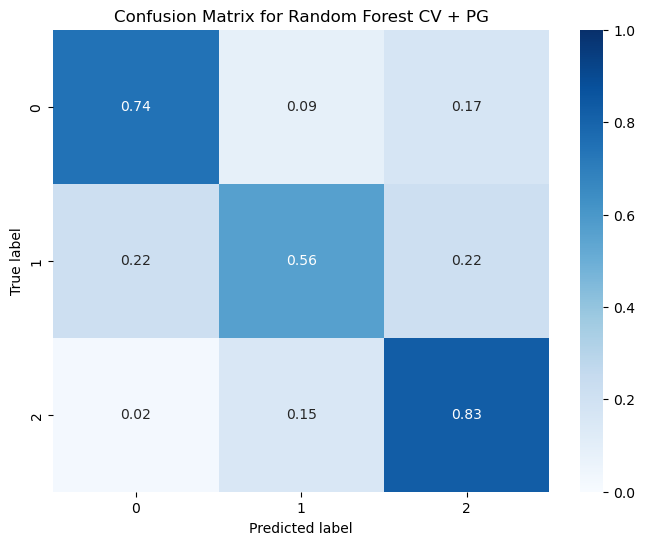

In [13]:
from pyspark.ml.classification import RandomForestClassifier
from pyspark.ml.tuning import ParamGridBuilder, CrossValidator
from pyspark.ml.evaluation import MulticlassClassificationEvaluator


rf = RandomForestClassifier(featuresCol='scaledFeatures',
                            labelCol='Credit_score_num')

evaluator = MulticlassClassificationEvaluator(labelCol='Credit_score_num', 
                                              predictionCol='prediction', 
                                              metricName='f1') # use f1 to compare best models


paramGrid = ParamGridBuilder() \
    .addGrid(rf.numTrees, [10, 20, 30, 40, 50]) \
        .build()
    
# cross val object
crossval = CrossValidator(estimator=rf,
                          estimatorParamMaps=paramGrid,
                          evaluator=evaluator,
                          numFolds=5)

print("Running model. This takes a while...")
cvModel = crossval.fit(train_data)

# Get best model from cross validator
bestModel = cvModel.bestModel
# save model
bestModel.save(f"{models_paths}/RandomForest/RandomForest_CV_PG")


predictions = bestModel.transform(test_data)

# Evaluate the best model
accuracy = evaluator.evaluate(predictions, {evaluator.metricName: "accuracy"})
f1 = evaluator.evaluate(predictions, {evaluator.metricName: "f1"})
weightedPrecision = evaluator.evaluate(predictions, {evaluator.metricName: "weightedPrecision"})
weightedRecall = evaluator.evaluate(predictions, {evaluator.metricName: "weightedRecall"})

print(f"Best Model Metrics: Accuracy = {accuracy}, F1 = {f1}, Weighted Precision = {weightedPrecision}, Weighted Recall = {weightedRecall}")
print("------------------------------------------------")
best_model_params = bestModel.explainParams()
print(f"Best model params:\n{best_model_params}")
print("------------------------------------------------")
pd_predictions = predictions.select(['prediction', 'Credit_score_num']).toPandas()
plot_confusion_matrix(pd_predictions['Credit_score_num'], pd_predictions['prediction'], "Random Forest CV + PG") # Send results to confusion matirx

### Principal features

In [14]:
metadata = transformed_df.schema['features'].metadata
attrs = metadata['ml_attr']['attrs']

features_info = []

# extract attrs info
for attr_type in ['numeric', 'binary']:
    if attr_type in attrs:
        features_info.extend(attrs[attr_type])

features_info = sorted(features_info, key=lambda x: x['idx'])

# Get importance from model (rf_is the last RF model created in the previous loop - 40 trees)
importances = bestModel.featureImportances

# Match feature names with their importances
feature_importance_list = [(f['name'], importances[f['idx']]) for f in features_info]
feature_importance_list

[('Month_num', 0.0024780633593746914),
 ('Age', 0.0012346621497214376),
 ('Annual_Income', 0.0035138427638047296),
 ('Monthly_Inhand_Salary', 0.002770875307399182),
 ('Occupation_oneHot_Lawyer', 3.2526119943747846e-05),
 ('Occupation_oneHot_Engineer', 4.2461262827054356e-05),
 ('Occupation_oneHot_Scientist', 2.9132819312155184e-05),
 ('Occupation_oneHot_Architect', 4.336644048272487e-05),
 ('Occupation_oneHot_Developer', 3.629357370274292e-05),
 ('Occupation_oneHot_Accountant', 0.0),
 ('Occupation_oneHot_Mechanic', 2.3938237066329627e-05),
 ('Occupation_oneHot_Entrepreneur', 3.864716107254601e-05),
 ('Occupation_oneHot_Teacher', 1.201282054252621e-06),
 ('Occupation_oneHot_Media_Manager', 5.492975744197193e-05),
 ('Occupation_oneHot_Journalist', 8.553480862075248e-06),
 ('Occupation_oneHot_Doctor', 1.0723679319137282e-05),
 ('Occupation_oneHot_Manager', 4.5249695895273535e-05),
 ('Occupation_oneHot_Musician', 2.8131526924023642e-05),
 ('Occupation_oneHot_Writer', 1.1801778207862367e-05

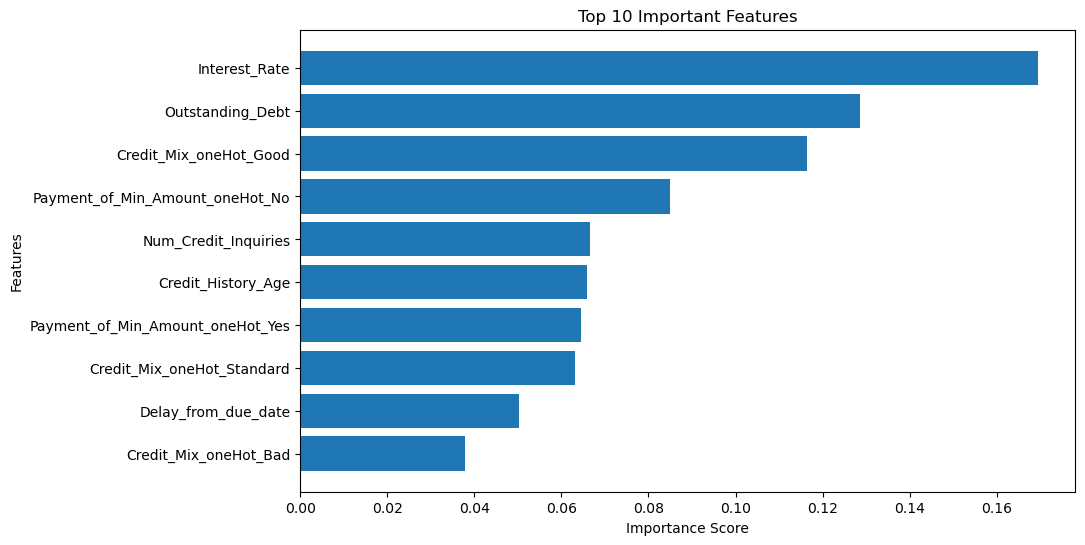

In [15]:
# Sort the features by importance
sorted_features = sorted(feature_importance_list, key=lambda x: x[1], reverse=True)

# Select top N features you want to display
top_n = 10
top_features, top_scores = zip(*sorted_features[:top_n])

plt.figure(figsize=(10, 6))
plt.barh(range(top_n), top_scores, align='center')
plt.yticks(range(top_n), top_features)
plt.gca().invert_yaxis()
plt.xlabel('Importance Score')
plt.ylabel('Features')
plt.title('Top 10 Important Features')
plt.show()

## MultiLayerPerceptron (crossValidation + paramGrid)

In [16]:
feature_vector = train_data.select("scaledFeatures").first()[0]
print(f"Feature vector len: {len(feature_vector)}")

Feature vector len: 57


Best Model Metrics: Accuracy = 0.7254433520169071, F1 = 0.7214281756638363, Weighted Precision = 0.7246424160960737, Weighted Recall = 0.725443352016907
Best model params:
blockSize: block size for stacking input data in matrices. Data is stacked within partitions. If block size is more than remaining data in a partition then it is adjusted to the size of this data. (default: 128, current: 128)
featuresCol: features column name. (default: features, current: scaledFeatures)
initialWeights: The initial weights of the model. (undefined)
labelCol: label column name. (default: label, current: Credit_score_num)
layers: Sizes of layers from input layer to output layer E.g., Array(780, 100, 10) means 780 inputs, one hidden layer with 100 neurons and output layer of 10 neurons. (current: [57, 30, 20, 3])
maxIter: max number of iterations (>= 0). (default: 100, current: 300)
predictionCol: prediction column name. (default: prediction)
probabilityCol: Column name for predicted class conditional p

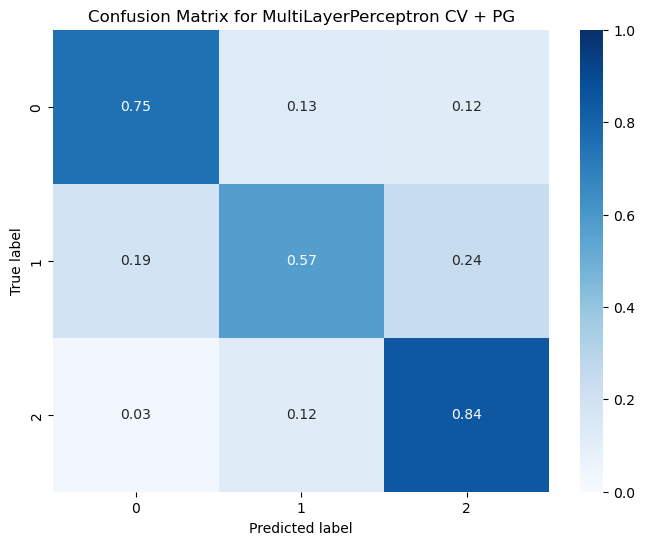

In [17]:
# https://spark.apache.org/docs/latest/ml-classification-regression.html#multilayer-perceptron-classifier
from pyspark.ml.classification import MultilayerPerceptronClassifier
from pyspark.ml.tuning import ParamGridBuilder, CrossValidator
from pyspark.ml.evaluation import MulticlassClassificationEvaluator


nn = MultilayerPerceptronClassifier(featuresCol='scaledFeatures', 
                                    labelCol='Credit_score_num', 
                                    blockSize=128, 
                                    seed=123, 
                                    maxIter=300)

evaluator = MulticlassClassificationEvaluator(labelCol='Credit_score_num', 
                                              predictionCol='prediction', 
                                              metricName='f1') # use f1 to compare best models


paramGrid = ParamGridBuilder() \
    .addGrid(nn.layers, [[len(feature_vector), 20, 10, 3],
                         [len(feature_vector), 30, 20, 3],
                         [len(feature_vector), 40, 30, 3]]) \
    .build()
    
# cross val object
crossval = CrossValidator(estimator=nn,
                          estimatorParamMaps=paramGrid,
                          evaluator=evaluator,
                          numFolds=5)

cvModel = crossval.fit(train_data)

# Get best model from cross validator
bestModel = cvModel.bestModel
# save model
bestModel.save(f"{models_paths}/MultiLayerPerceptron/MultiLayerPercep_CV_PG")


predictions = bestModel.transform(test_data)

# Evaluate the best model
accuracy = evaluator.evaluate(predictions, {evaluator.metricName: "accuracy"})
f1 = evaluator.evaluate(predictions, {evaluator.metricName: "f1"})
weightedPrecision = evaluator.evaluate(predictions, {evaluator.metricName: "weightedPrecision"})
weightedRecall = evaluator.evaluate(predictions, {evaluator.metricName: "weightedRecall"})

print(f"Best Model Metrics: Accuracy = {accuracy}, F1 = {f1}, Weighted Precision = {weightedPrecision}, Weighted Recall = {weightedRecall}")

best_model_params = bestModel.explainParams()
print(f"Best model params:\n{best_model_params}")

pd_predictions = predictions.select(['prediction', 'Credit_score_num']).toPandas()
plot_confusion_matrix(pd_predictions['Credit_score_num'], pd_predictions['prediction'], "MultiLayerPerceptron CV + PG") # Send results to confusion matirx

## Multinomial Logistic Regression (crossValidation + paramGrid)

Running model. This takes a while...
Best Model Metrics: Accuracy = 0.6853808692456125, F1 = 0.6828145317210692, Weighted Precision = 0.6866670858637987, Weighted Recall = 0.6853808692456125
------------------------------------------------
Best model params:
aggregationDepth: suggested depth for treeAggregate (>= 2). (default: 2)
elasticNetParam: the ElasticNet mixing parameter, in range [0, 1]. For alpha = 0, the penalty is an L2 penalty. For alpha = 1, it is an L1 penalty. (default: 0.0)
family: The name of family which is a description of the label distribution to be used in the model. Supported options: auto, binomial, multinomial (default: auto, current: multinomial)
featuresCol: features column name. (default: features, current: scaledFeatures)
fitIntercept: whether to fit an intercept term. (default: True)
labelCol: label column name. (default: label, current: Credit_score_num)
lowerBoundsOnCoefficients: The lower bounds on coefficients if fitting under bound constrained optimiz

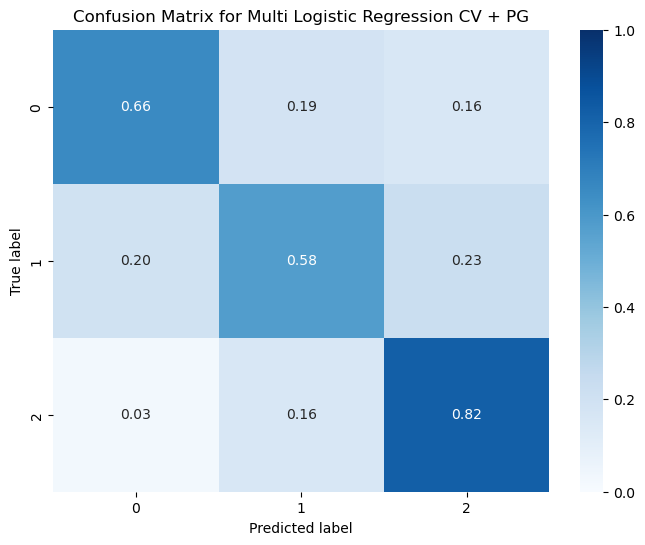

In [18]:
from pyspark.ml.classification import LogisticRegression
from pyspark.ml.tuning import ParamGridBuilder, CrossValidator
from pyspark.ml.evaluation import MulticlassClassificationEvaluator


mlr = LogisticRegression(featuresCol='scaledFeatures',
                         labelCol='Credit_score_num',
                         maxIter=300,
                         family="multinomial")

evaluator = MulticlassClassificationEvaluator(labelCol='Credit_score_num', 
                                              predictionCol='prediction', 
                                              metricName='f1') # use f1 to compare best models


paramGrid = ParamGridBuilder() \
            .addGrid(mlr.regParam, [0.0, 0.1, 0.5, 1.0]) \
            .build()
    
# cross val object
crossval = CrossValidator(estimator=mlr,
                          estimatorParamMaps=paramGrid,
                          evaluator=evaluator,
                          numFolds=5)

print("Running model. This takes a while...")
cvModel = crossval.fit(train_data)

# Get best model from cross validator
bestModel = cvModel.bestModel
# save model
bestModel.save(f"{models_paths}/MultinomialLogisticRegression/MultiLogReg_CV_PG")


predictions = bestModel.transform(test_data)

# Evaluate the best model
accuracy = evaluator.evaluate(predictions, {evaluator.metricName: "accuracy"})
f1 = evaluator.evaluate(predictions, {evaluator.metricName: "f1"})
weightedPrecision = evaluator.evaluate(predictions, {evaluator.metricName: "weightedPrecision"})
weightedRecall = evaluator.evaluate(predictions, {evaluator.metricName: "weightedRecall"})

print(f"Best Model Metrics: Accuracy = {accuracy}, F1 = {f1}, Weighted Precision = {weightedPrecision}, Weighted Recall = {weightedRecall}")
print("------------------------------------------------")
best_model_params = bestModel.explainParams()
print(f"Best model params:\n{best_model_params}")
print("------------------------------------------------")
pd_predictions = predictions.select(['prediction', 'Credit_score_num']).toPandas()
plot_confusion_matrix(pd_predictions['Credit_score_num'], pd_predictions['prediction'], "Multi Logistic Regression CV + PG") # Send results to confusion matirx

# PCA

None of the models were actually good

Random Forest with 40 was the least bad model. We'll try to improve it with PCA

## MLP + PCA + CV + PG

Training/Fitting model. This takes a while...
-------------------------------------------------------------
Best Model Metrics: Accuracy = 0.6987962877882937, F1 = 0.695583338139759, Weighted Precision = 0.6987411710028264, Weighted Recall = 0.6987962877882936
-------------------------------------------------------------
Best model params:
blockSize: block size for stacking input data in matrices. Data is stacked within partitions. If block size is more than remaining data in a partition then it is adjusted to the size of this data. (default: 128, current: 128)
featuresCol: features column name. (default: features, current: pcaFeatures)
initialWeights: The initial weights of the model. (undefined)
labelCol: label column name. (default: label, current: Credit_score_num)
layers: Sizes of layers from input layer to output layer E.g., Array(780, 100, 10) means 780 inputs, one hidden layer with 100 neurons and output layer of 10 neurons. (current: [10, 30, 20, 3])
maxIter: max number of ite

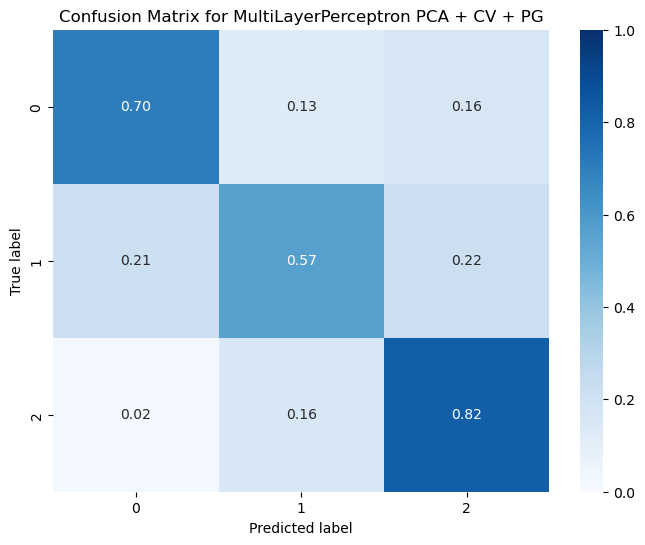

In [19]:
from pyspark.ml import Pipeline
from pyspark.ml.feature import PCA
from pyspark.ml.classification import MultilayerPerceptronClassifier
from pyspark.ml.tuning import ParamGridBuilder, CrossValidator
from pyspark.ml.evaluation import MulticlassClassificationEvaluator
from itertools import chain


# PCA model (no K)
pca = PCA(inputCol='scaledFeatures', outputCol='pcaFeatures')
# Classifier model
nn = MultilayerPerceptronClassifier(featuresCol='pcaFeatures',
                                    labelCol='Credit_score_num',
                                    blockSize=128,
                                    seed=123,
                                    maxIter=300)
# pca_pipeline = pca + model (nn)
pca_pipeline = Pipeline(stages=[pca, nn])

# Params to test. NN layers + K values
# NOTE: 30, 20, 3 was the best previous model layers (without PCA)
# NOTE: K = 5, 10 or 20
# NOTE: Need to split paramGrids to ensure that that K matches the first layer of the model
# Individual parameter grids
paramGrid5 = ParamGridBuilder().addGrid(pca.k, [5]).addGrid(nn.layers, [[5, 30, 20, 3]]).build()
paramGrid10 = ParamGridBuilder().addGrid(pca.k, [10]).addGrid(nn.layers, [[10, 30, 20, 3]]).build()
paramGrid20 = ParamGridBuilder().addGrid(pca.k, [20]).addGrid(nn.layers, [[20, 30, 20, 3]]).build()

paramGrid = list(chain(paramGrid5, paramGrid10, paramGrid20)) # creates a single list with every paramGridX

crossval = CrossValidator(estimator=pca_pipeline, 
                          estimatorParamMaps=paramGrid, 
                          evaluator=evaluator, 
                          numFolds=5)


evaluator = MulticlassClassificationEvaluator(labelCol='Credit_score_num', predictionCol='prediction', metricName='f1')
crossval = CrossValidator(estimator=pca_pipeline, estimatorParamMaps=paramGrid, evaluator=evaluator, numFolds=5)

# NOTE: Original train_data will be 'PCA' in the new pipeline
print("Training/Fitting model. This takes a while...")
cvModel = crossval.fit(train_data)
bestModel = cvModel.bestModel
bestModel.save(f"{models_paths}/MultiLayerPerceptron/MultiLayerPercep_CV_PG_PCA")


predictions = bestModel.transform(test_data)

# Evaluate the best model using different metrics
accuracy = evaluator.evaluate(predictions, {evaluator.metricName: "accuracy"})
f1 = evaluator.evaluate(predictions, {evaluator.metricName: "f1"})
weightedPrecision = evaluator.evaluate(predictions, {evaluator.metricName: "weightedPrecision"})
weightedRecall = evaluator.evaluate(predictions, {evaluator.metricName: "weightedRecall"})

print("-------------------------------------------------------------")
print(f"Best Model Metrics: Accuracy = {accuracy}, F1 = {f1}, Weighted Precision = {weightedPrecision}, Weighted Recall = {weightedRecall}")

# Get best params (from nn model)
print("-------------------------------------------------------------")
best_model_params = bestModel.stages[-1].explainParams() # Last stage is the NN model
print(f"Best model params:\n{best_model_params}")

# Confusion matrix
print("-------------------------------------------------------------")
pd_predictions = predictions.select(['prediction', 'Credit_score_num']).toPandas()
plot_confusion_matrix(pd_predictions['Credit_score_num'], pd_predictions['prediction'], "MultiLayerPerceptron PCA + CV + PG")


# Stop spark

In [20]:
spark.stop()